In [1]:
# --- 0. Install & Import libraries ---
# Run this cell if libraries are missing
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn missingno --quiet

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os

# Display & plot settings
pd.options.display.max_columns = 50
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11

# Create folder for figures
os.makedirs('figures', exist_ok=True)



# **1. Objective**
- Explore the Kaggle Titanic dataset
- Clean the data
- Create new features
- Inspect survival patterns (Sex, Class, Age, Family)
- Visualize key patterns & correlations
- Train simple predictive models (Logistic Regression / Random Forest)
- Save outputs: cleaned CSV, annotated figures, key findings


In [2]:
# --- 2. Load data ---
DATA_PATH = 'train.csv'
try:
    df = pd.read_csv(DATA_PATH)
    print("Loaded:", DATA_PATH)
except FileNotFoundError:
    print("train.csv not found in current folder. Put train.csv in notebook folder or provide full path.")
    raise

df.head()


Loaded: train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


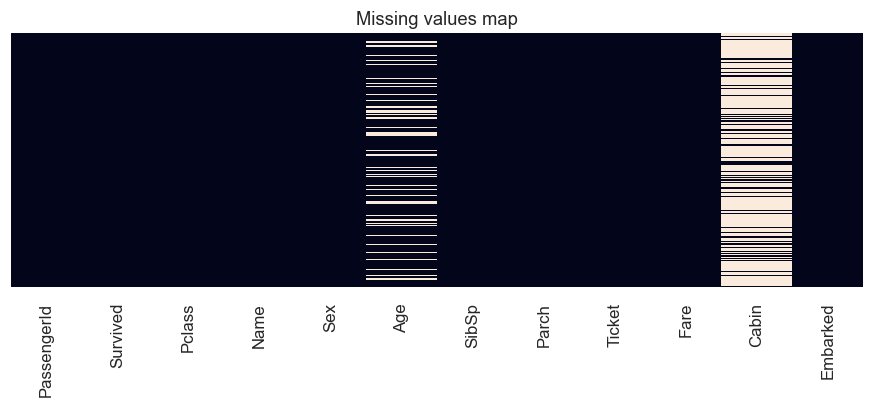

<Axes: >

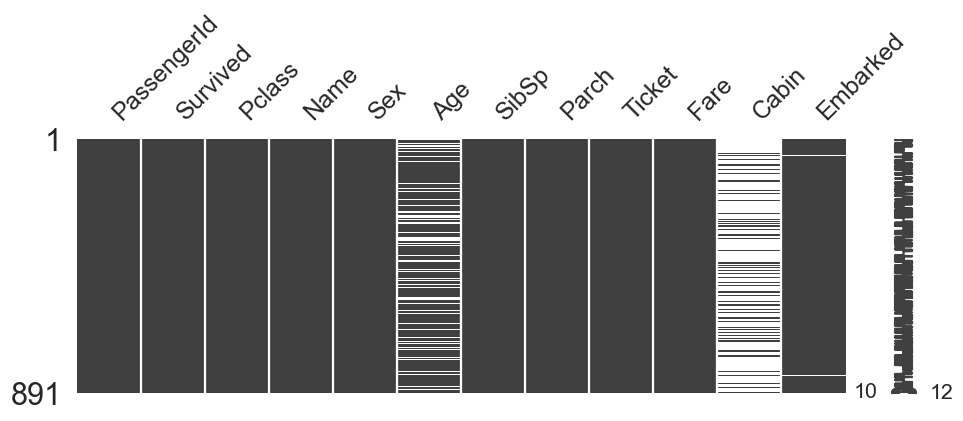

In [3]:
# Quick data info
df.shape
df.info()
df.describe(include='all').T
df.isnull().sum().sort_values(ascending=False)

# Visualize missing values
plt.figure(figsize=(10,3))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Missing values map')
plt.show()

msno.matrix(df, figsize=(10,3))


# **3. Data Cleaning**
- Fill missing values
- Convert types
- Extract features


In [4]:
# Work on a copy
data = df.copy()

# Pclass as categorical
data['Pclass'] = data['Pclass'].astype('category')

# Fill missing Embarked & Fare
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# Age imputation: median by Sex + Pclass
age_median_by_group = data.groupby(['Sex', 'Pclass'], observed=False)['Age'].transform('median')
data['Age'] = data['Age'].fillna(age_median_by_group)

# Deck extraction from Cabin
data['Deck'] = data['Cabin'].str.get(0).fillna('U').astype('category')

# Family features
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Title extraction & normalization
data['Title'] = data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace({
    'Mlle':'Miss','Ms':'Miss','Mme':'Mrs',
    'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare','Don':'Rare','Dr':'Rare',
    'Major':'Rare','Rev':'Rare','Sir':'Rare','Jonkheer':'Rare','Dona':'Rare'
})
data['Title'] = data['Title'].astype('category')

# Sex binary for modeling
data['Sex_code'] = data['Sex'].map({'male':0,'female':1})

# Verify no remaining missing
data[['Age','Fare','Embarked','Deck']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Age       891 non-null    float64 
 1   Fare      891 non-null    float64 
 2   Embarked  891 non-null    object  
 3   Deck      891 non-null    category
dtypes: category(1), float64(2), object(1)
memory usage: 22.2+ KB


# **4. Exploratory Data Analysis (EDA)**


In [5]:
# Overall survival
overall_survival = data['Survived'].mean()
print(f"Overall survival rate: {overall_survival:.2%}")

# Survival by Sex, Pclass, Title, IsAlone
for col in ['Sex','Pclass','Title','IsAlone']:
    print(f"\nSurvival by {col}:\n", data.groupby(col, observed=False)['Survived'].mean().map("{:.2%}".format))


Overall survival rate: 38.38%

Survival by Sex:
 Sex
female    74.20%
male      18.89%
Name: Survived, dtype: object

Survival by Pclass:
 Pclass
1    62.96%
2    47.28%
3    24.24%
Name: Survived, dtype: object

Survival by Title:
 Title
Master    57.50%
Miss      70.27%
Mr        15.67%
Mrs       79.37%
Rare      34.78%
Name: Survived, dtype: object

Survival by IsAlone:
 IsAlone
0    50.56%
1    30.35%
Name: Survived, dtype: object


In [6]:
# Pivot: Pclass x Sex
survival_pivot = data.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean', observed=False)
survival_pivot


Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [7]:
# Visualizations
def annotate_bars(ax, fmt="{:.0f}", offset=4):
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(fmt.format(y if fmt != "{:.1%}" else y),
                    (x, y), ha='center', va='bottom', xytext=(0, offset),
                    textcoords='offset points', fontsize=10)

# Survival by Sex (counts)
plt.figure(figsize=(7,4))
ax = sns.countplot(x='Survived', hue='Sex', data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['Died','Survived'])
for p in ax.patches:
    ax.annotate(int(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', xytext=(0,4), textcoords='offset points', fontsize=9)
plt.title('Survival Count by Sex')
plt.tight_layout()
plt.savefig('figures/survival_by_sex.png', dpi=300, bbox_inches='tight')
plt.close()


In [8]:
# Survival by Pclass
survival_by_class = data.groupby('Pclass', observed=False)['Survived'].mean().sort_index()
plt.figure(figsize=(6,4))
ax = sns.barplot(x=survival_by_class.index.astype(str), y=survival_by_class.values)
ax.set_xlabel('Pclass'); ax.set_ylabel('Survival Rate'); ax.set_ylim(0,1)
for i, v in enumerate(survival_by_class.values):
    ax.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=10)
plt.title('Survival Rate by Passenger Class')
plt.tight_layout()
plt.savefig('figures/survival_by_pclass.png', dpi=300, bbox_inches='tight')
plt.close()


In [9]:
# Pclass x Sex heatmap
plt.figure(figsize=(6,3))
sns.heatmap(survival_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Survival Rate by Pclass and Sex')
plt.tight_layout()
plt.savefig('figures/heatmap_pclass_sex.png', dpi=300, bbox_inches='tight')
plt.close()


In [10]:
# Numeric correlation
num_cols = ['Survived','Pclass','Age','SibSp','Parch','Fare','FamilySize','IsAlone','Sex_code']
corr = data[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation (numeric features)')
plt.tight_layout()
plt.savefig('figures/correlation_numeric.png', dpi=300, bbox_inches='tight')
plt.close()


In [11]:
# Age distribution by survival
plt.figure(figsize=(8,4))
sns.boxplot(x='Survived', y='Age', data=data)
plt.xticks([0,1], ['Died','Survived'])
plt.title('Age Distribution by Survival')
plt.tight_layout()
plt.savefig('figures/age_by_survival.png', dpi=300, bbox_inches='tight')
plt.close()


In [12]:
# Log transform Fare
data['Fare_log'] = np.log1p(data['Fare'])
plt.figure(figsize=(8,3))
sns.histplot(data['Fare_log'], bins=40, kde=False)
plt.title('Log-transformed Fare distribution')
plt.tight_layout()
plt.savefig('figures/fare_log_distribution.png', dpi=300, bbox_inches='tight')
plt.close()


# **5. Feature Engineering**
- Age bins
- Deck, Title already created
- Family features already created


In [13]:
# Age bins
data['AgeBin'] = pd.cut(data['Age'], bins=[0,12,20,40,60,100], labels=['Child','Teen','Adult','MidAge','Senior'])


In [14]:
# --- 6. Save cleaned data & summary ---
data.to_csv('titanic_cleaned.csv', index=False)
print("Saved titanic_cleaned.csv")

# Optional: Key findings text file
with open('titanic_key_findings.txt','w', encoding='utf-8') as f:
    f.write("Key findings (computed)\n\n")
    f.write(f"Overall survival: {overall_survival:.2%}\n")
    for col in ['Sex','Pclass','Title','IsAlone']:
        grp = data.groupby(col, observed=False)['Survived'].mean()
        f.write(f"\n{col}:\n")
        for idx,val in grp.items():
            f.write(f"  {idx}: {val:.2%}\n")
print("Saved summary to titanic_key_findings.txt")


Saved titanic_cleaned.csv
Saved summary to titanic_key_findings.txt


# **7. Model Training**
- Logistic Regression & Random Forest example


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features & target
model_df = data[['Survived','Pclass','Sex_code','Age','Fare','FamilySize']].dropna()
X = model_df[['Pclass','Sex_code','Age','Fare','FamilySize']].copy()
y = model_df['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# Random Forest
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42)
clf_rf.fit(X_train, y_train)
pred_rf = clf_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))

# Feature importances
importances = pd.Series(clf_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importances:\n", importances)


Logistic Regression Accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

Random Forest Accuracy: 0.8100558659217877
Feature importances:
 Fare          0.303041
Sex_code      0.273516
Age           0.261265
Pclass        0.084576
FamilySize    0.077602
dtype: float64


# ✅ **8. Notebook Summary**
**Dataset:** Kaggle Titanic train.csv  
**Environment:** Python 3.x, pandas, seaborn, matplotlib, scikit-learn

**Steps:**
1. Data cleaning: Age imputation, fill missing, extract Deck & Title
2. Feature engineering: FamilySize, IsAlone, AgeBin, Title categories
3. EDA & visualizations: survival by Sex, Pclass, Title, Age; correlations; boxplots
4. Saved cleaned dataset & 6+ annotated figures
5. Model training: Logistic Regression & Random Forest, feature importance
6. Key findings summary saved to text file
